## 3-Way ANOVA

The three-way ANOVA is an extension of the two-way ANOVA for assessing whether there is an interaction effect between three independent categorical variables on a continuous outcome variable.

We’ll use the **headache dataset** [datarium package], which contains the measures of migraine headache episode pain score in 72 participants treated with three different treatments. The participants include 36 males and 36 females. Males and females were further subdivided into whether they were at low or high risk of migraine.

We want to understand how each independent variable (type of treatments, risk of migraine and gender) interact to predict the pain score.


### Descriptive statistics

In [1]:
import pandas as pd

# URL to the CSV file
url = 'https://github.com/kflisikowski/ds/raw/master/headache.csv'

# Read the data from the CSV file into a DataFrame
df = pd.read_csv(url)

# Display the DataFrame
print(df)

    id  gender  risk treatment  pain_score
0    1    male   low         X   79.311695
1    2    male   low         X   76.843399
2    3    male   low         X   70.832421
3    4    male   low         X   81.163944
4    5    male   low         X   75.052213
..  ..     ...   ...       ...         ...
67  68  female  high         Z   82.786300
68  69  female  high         Z   81.265636
69  70  female  high         Z   80.419553
70  71  female  high         Z   87.142265
71  72  female  high         Z   79.609041

[72 rows x 5 columns]


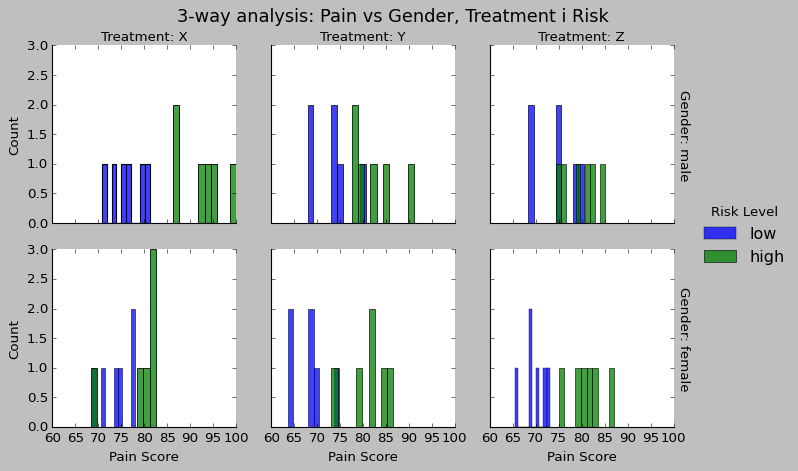

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the plot
g = sns.FacetGrid(df, col="treatment", row="gender",hue="risk", margin_titles=True)
g.map_dataframe(sns.histplot, x="pain_score", bins=10)


g.add_legend(title="Risk Level")
g.set_axis_labels("Pain Score", "Count")
g.set_titles(col_template="Treatment: {col_name}", row_template="Gender: {row_name}")

g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('3-way analysis: Pain vs Gender, Treatment i Risk', fontsize=16)

# Show the plot
plt.style.use('classic')

plt.show()

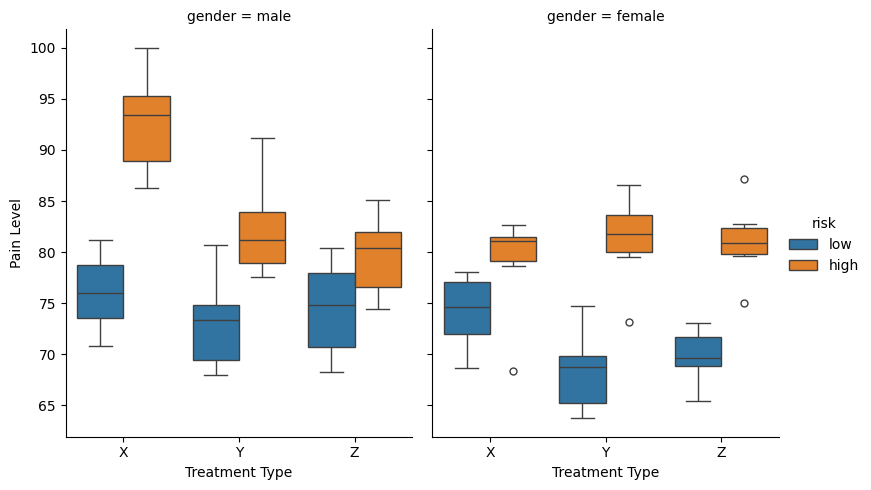

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

g = sns.catplot(
    data=df, 
    x="treatment",       
    y="pain_score",    
    hue="risk",          
    col="gender",        
    kind="box",         
    height=5,         
    aspect=0.8         
)

g.set_axis_labels("Treatment Type", "Pain Level")
plt.show()

In [8]:
# Group the data by gender and education level and calculate mean and standard deviation of score
summary_stats = df.groupby(['gender', 'treatment', 'risk'])['pain_score'].agg(['mean', 'std']).reset_index()

# Rename columns for clarity
summary_stats.columns = ['gender', 'treatment','risk', 'mean_score', 'std_score']

# Display the summary statistics
print(summary_stats)

    gender treatment  risk  mean_score  std_score
0   female         X  high   78.865059   5.316489
1   female         X   low   74.156231   3.690272
2   female         Y  high   81.175304   4.619387
3   female         Y   low   68.361925   4.081842
4   female         Z  high   81.035142   3.984886
5   female         Z   low   69.779555   2.719645
6     male         X  high   92.738847   5.116095
7     male         X   low   76.051783   3.854876
8     male         Y  high   82.341542   5.000898
9     male         Y   low   73.138772   4.765061
10    male         Z  high   79.680736   4.045885
11    male         Z   low   74.455863   4.888865


## Assumptions


### Outliers

In [9]:
# Function to identify outliers using the IQR method
def identify_outliers(group):
    Q1 = group['pain_score'].quantile(0.25)
    Q3 = group['pain_score'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = group[(group['pain_score'] < lower_bound) | (group['pain_score'] > upper_bound)]
    return outliers

# Group the data by gender and education level and identify outliers
outliers = df.groupby(['gender', 'treatment','risk']).apply(identify_outliers).reset_index(drop=True)

# Display the outliers
print(outliers)

   id  gender  risk treatment  pain_score
0  57  female  high         X   68.360185
1  62  female  high         Y   73.144392
2  67  female  high         Z   74.988057
3  71  female  high         Z   87.142265


C:\Users\rgfif\AppData\Local\Temp\ipykernel_35512\1235955987.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  outliers = df.groupby(['gender', 'treatment','risk']).apply(identify_outliers).reset_index(drop=True)


### Normality

In [10]:
from scipy.stats import shapiro

# Function to perform the Shapiro-Wilk test
def shapiro_test(group):
    stat, p_value = shapiro(group['pain_score'])
    return pd.Series({'W': stat, 'p_value': p_value})

# Group the data by gender and education level and apply the Shapiro-Wilk test
shapiro_results = df.groupby(['gender', 'treatment','risk']).apply(shapiro_test).reset_index()

# Display the Shapiro-Wilk test results
print(shapiro_results)

    gender treatment  risk         W   p_value
0   female         X  high  0.714180  0.008690
1   female         X   low  0.932551  0.599938
2   female         Y  high  0.939332  0.653824
3   female         Y   low  0.926774  0.555428
4   female         Z  high  0.971232  0.900604
5   female         Z   low  0.957585  0.800946
6     male         X  high  0.958434  0.807595
7     male         X   low  0.982194  0.961928
8     male         Y  high  0.901730  0.384257
9     male         Y   low  0.920272  0.507324
10    male         Z  high  0.955478  0.784303
11    male         Z   low  0.924051  0.535007


C:\Users\rgfif\AppData\Local\Temp\ipykernel_35512\2243781328.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shapiro_results = df.groupby(['gender', 'treatment','risk']).apply(shapiro_test).reset_index()


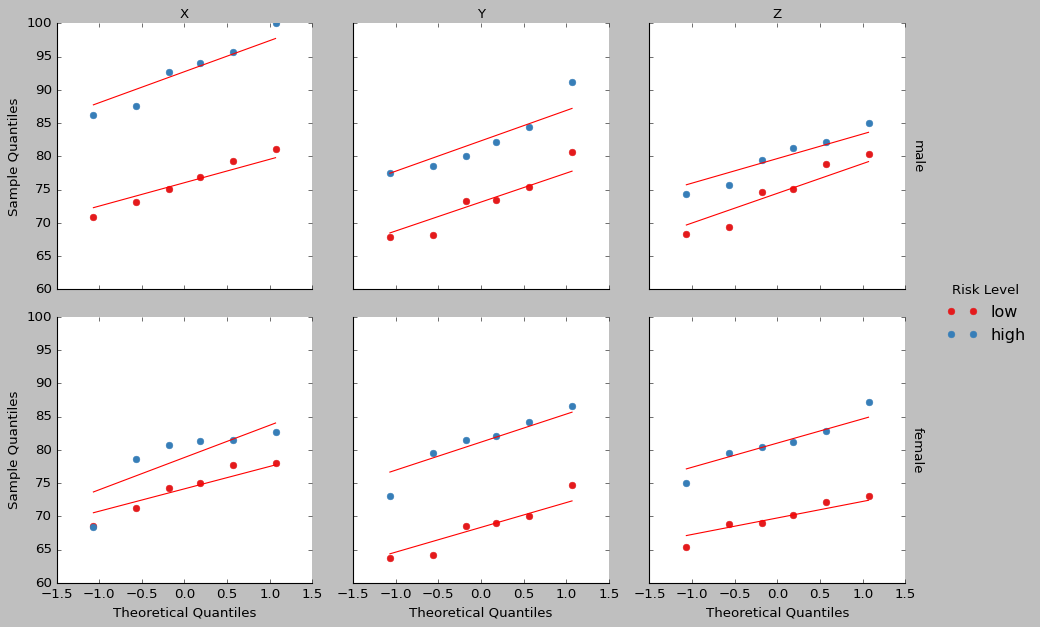

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Function to create QQ plot
def qqplot(x, **kwargs):
    ax = plt.gca()
    color = kwargs.get('color')
    label = kwargs.get('label')
    sm.qqplot(x, line='s', ax=ax, 
            markerfacecolor=color, 
            markeredgecolor=color,
            label=label)    
    ax.get_lines()[-1].set_color('red')

# Create a FacetGrid for the QQ plots
g = sns.FacetGrid(df, col="treatment", row="gender",hue='risk', margin_titles=True, height=4, palette='Set1')

# Map the QQ plot function to the FacetGrid
g.map(qqplot, 'pain_score')

# Add titles and labels
g.set_axis_labels("Theoretical Quantiles", "Sample Quantiles")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(title="Risk Level")

# Show the plot
plt.show()

A Shapiro-Wilk test was performed to assess the assumption of normality within each subgroup. The assumption was met for 11 out of the 12 groups (p>0.05). A significant deviation from normality was observed only in the high-risk female group receiving treatment X (W=0.714,p=0.009). This deviation was primarily attributed to the presence of outliers identified within this specific group.

Despite the small cell size ($n=6$), the decision was made to retain these outliers and proceed with the ANOVA. This approach is justified as the violation of normality is isolated to a single experimental group, and ANOVA is considered relatively robust to such deviations, provided that the assumption of homogeneity of variance is met.

### Homogeneity of variance

In [19]:
from scipy.stats import levene
# Perform Levene's test
# Group the data by gender and education level and extract the score values
grouped_data = df.groupby(['gender', 'treatment','risk'])['pain_score'].apply(list)

# Perform Levene's test
stat, p_value = levene(*grouped_data)

# Display the results
print(f"Levene's test statistic: {stat}")
print(f"p-value: {p_value}")

Levene's test statistic: 0.17859528084995452
p-value: 0.9982136500456728


## Anova


In [23]:
from pingouin import anova
anova_results = anova(data=df, dv='pain_score', between=['gender','treatment','risk'])

# Display ANOVA results
print(anova_results)

                      Source           SS    DF           MS          F  \
0                     gender   313.358773   1.0   313.358773  16.195746   
1                  treatment   283.168031   2.0   141.584016   7.317679   
2                       risk  1793.555757   1.0  1793.555757  92.698774   
3         gender * treatment   129.182324   2.0    64.591162   3.338353   
4              gender * risk     2.730584   1.0     2.730584   0.141128   
5           treatment * risk    27.595016   2.0    13.797508   0.713115   
6  gender * treatment * risk   286.595625   2.0   143.297812   7.406255   
7                   Residual  1160.892871  60.0    19.348215        NaN   

          p-unc       np2  
0  1.625409e-04  0.212554  
1  1.432844e-03  0.196091  
2  8.799980e-14  0.607070  
3  4.220011e-02  0.100135  
4  7.084867e-01  0.002347  
5  4.942214e-01  0.023219  
6  1.334476e-03  0.197995  
7           NaN       NaN  


The analysis revealed statistically significant main effects and interactions, confirming that the differences between groups are meaningful. Consequently, we are proceeding to post-hoc analysis to further investigate the specific nature of these complex relationships



### Post-hoc tests

If there is a significant 3-way interaction effect, you can decompose it into:

-    Simple two-way interaction: run two-way interaction at each level of third variable,
-    Simple simple main effect: run one-way model at each level of second variable,
-    Simple simple pairwise comparisons: run pairwise or other post-hoc comparisons if necessary.

If you do not have a statistically significant three-way interaction, you need to determine whether you have any statistically significant two-way interaction from the ANOVA output. You can follow up a significant two-way interaction by simple main effects analyses and pairwise comparisons between groups if necessary.


### Two-way interactions

In [ ]:
def group_anova(group):
    results = anova(data=group, dv='pain_score', between=['treatment','risk'])
    return results

anova_results = df.groupby('gender').apply(group_anova).reset_index()
print(anova_results)

   gender  level_1            Source          SS  DF          MS          F  \
0  female        0         treatment   18.639649   2    9.319825   0.542065   
1  female        1              risk  828.161356   1  828.161356  48.168001   
2  female        2  treatment * risk  110.970499   2   55.485249   3.227165   
3  female        3          Residual  515.795551  30   17.193185        NaN   
4    male        0         treatment  393.710706   2  196.855353   9.154682   
5    male        1              risk  968.124984   1  968.124984  45.022276   
6    male        2  treatment * risk  203.220142   2  101.610071   4.725337   
7    male        3          Residual  645.097320  30   21.503244        NaN   

          p-unc       np2  
0  5.871351e-01  0.034877  
1  1.042751e-07  0.616211  
2  5.377519e-02  0.177053  
3           NaN       NaN  
4  7.876787e-04  0.379002  
5  1.954190e-07  0.600119  
6  1.644381e-02  0.239557  
7           NaN       NaN  


C:\Users\rgfif\AppData\Local\Temp\ipykernel_35512\1413793349.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  anova_results = df.groupby('gender').apply(group_anova).reset_index()


### Main effects

In [33]:

df_men = df[df['gender'] == 'male']
def check_treatment_effect(group):
    return anova(data=group, dv='pain_score', between='treatment')

step2_results = df_men.groupby('risk').apply(check_treatment_effect).reset_index()

print(step2_results)

   risk  level_1     Source  ddof1  ddof2          F     p-unc       np2
0  high        0  treatment      2     15  12.687808  0.000595  0.628489
1   low        0  treatment      2     15   0.623132  0.549583  0.076711


C:\Users\rgfif\AppData\Local\Temp\ipykernel_35512\1805284206.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  step2_results = df_men.groupby('risk').apply(check_treatment_effect).reset_index()


### Pairwise comparisons

In [35]:
import pingouin as pg
men_high_risk = df[(df['gender'] == 'male') & (df['risk'] == 'high')]
tukey_results = pg.pairwise_tukey(data=men_high_risk, dv='pain_score', between='treatment')
print(tukey_results)

   A  B    mean(A)    mean(B)       diff        se         T   p-tukey  \
0  X  Y  92.738847  82.341542  10.397305  2.739679  3.795081  0.004712   
1  X  Z  92.738847  79.680736  13.058111  2.739679  4.766292  0.000688   
2  Y  Z  82.341542  79.680736   2.660806  2.739679  0.971211  0.605446   

     hedges  
0  1.897182  
1  2.613461  
2  0.539983  


## Conclusions

The analysis demonstrates that treatment efficacy is not universal but relies heavily on the patient's gender and risk profile. For women, pain scores were driven exclusively by their baseline risk level, with no significant differences found between medications. However, for high-risk men, the choice of therapy proved critical: Treatment X was significantly less effective than Treatments Y and Z, which provided superior and comparable pain relief.